# Multi-Compartment Spherical Mean Technique

The recently proposed Multi-Compartment Spherical Mean Technique (MC-SMT) model [1] is a spherical convolution-based technique, which separates intra- from extra-axonal diffusion inside the spherical convolution kernel as

$$
\begin{align}
\begin{aligned}
 E_{\textrm{MC-SMT}}= \overbrace{\operatorname{FOD}}^{\textrm{Fiber Distribution}}\,*_{\mathbb{S}^2}\,\left[\underbrace{f_r\overbrace{E_r(\lambda_\parallel)}^{\textrm{Stick}}}_{\textrm{Intra-Axonal}}+\underbrace{(1-f_r)\overbrace{E_h(\lambda_\parallel|\lambda_\perp^{\textrm{tort}})}^{\textrm{Zeppelin}}}_{\textrm{Hindered Extra-Axonal}}\right].
\end{aligned}
\end{align}$$

The formulation of MC-SMT finds similarities in models such as NODDI, but stands apart in only considering the spherical mean of the signal at every acquisition shell, as used in the Spherical Mean Technique (SMT) [2].

SMT observes that if the FOD is a probability density (i.e. integrated to unity) then spherical mean of the signal and the convolution kernel must be the same
\begin{equation}
\int_{\mathbb{S}^2}E_b(\textbf{g})d\textbf{g}=\int_{\mathbb{S}^2}(\operatorname{FOD}\,*_{\mathbb{S}^2}\,K)_b(\textbf{g})d\textbf{g}=\int_{\mathbb{S}^2}K_b(\textbf{g})d\textbf{g}=\epsilon_K(b,\lambda_\perp,\lambda_\parallel).
\end{equation}
The estimation of the multi-compartment kernel using SMT enables the characterization of per-axon micro-environments, as the effects of axon dispersion and crossings are only contained in the FOD.

Advantages:
- Insensitive to axon dispersion.

Limitations:
- Biased in the presence of non-white matter tissues (CSF)
- Only accounts for average of tissue properties in crossing configurations, which potentially each have different properties.

### References
[1] Kaden, Enrico, et al. "Multi-compartment microscopic diffusion imaging." NeuroImage 139 (2016): 346-359.  
[2] Kaden, Enrico, et al. "Quantitative mapping of the per‐axon diffusion coefficients in brain white matter." Magnetic resonance in medicine 75.4 (2016): 1752-1763.

# Modelfitting on Monte-Carlo-simulated data

In [1]:
from microstruktur.data import saved_acquisition_schemes, saved_data
scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

synthetic_data_parallel = saved_data.synthetic_camino_data_parallel()
synthetic_data_dispersed = saved_data.synthetic_camino_data_dispersed()

In [2]:
from microstruktur.signal_models import spherical_mean_models
stick_mean = spherical_mean_models.C1StickSphericalMean()
zeppelin_mean = spherical_mean_models.G4ZeppelinSphericalMean()

In [3]:
from microstruktur.signal_models.utils import (
    T1_tortuosity, parameter_equality)

parameter_links_smt = [
    (  # tortuosity assumption
        zeppelin_mean, 'lambda_perp',
        T1_tortuosity, [
            (None, 'partial_volume_0'),
            (stick_mean, 'lambda_par')
        ]
    ),
    (  # equal parallel diffusivities
         zeppelin_mean, 'lambda_par',
         parameter_equality, [
            (stick_mean, 'lambda_par')
        ]
     )
]

In [4]:
from microstruktur.core import modeling_framework
mcsmt_mod = modeling_framework.MultiCompartmentMicrostructureModel(
    acquisition_scheme=scheme,
    models=[stick_mean, zeppelin_mean],
    parameter_links=parameter_links_smt
)

In [5]:
mcsmt_fit = mcsmt_mod.fit(synthetic_data_parallel.signal_attenuation)
mcsmt_fit_dispersed = mcsmt_mod.fit(synthetic_data_dispersed.signal_attenuation)

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 1.68507218361 seconds.
Average of 0.00510627934427 seconds per voxel.
Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 14.5070919991 seconds.
Average of 0.00488454276062 seconds per voxel.


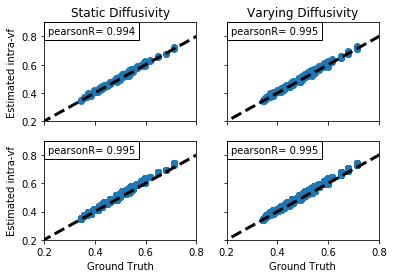

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

saved_data.visualize_correlation_camino_and_estimated_fractions(
    mcsmt_fit.fitted_parameters['partial_volume_0'].squeeze(),
    mcsmt_fit_dispersed.fitted_parameters['partial_volume_0'].squeeze())

## Real data example

In [7]:
data_hcp = saved_data.wu_minn_hcp_coronal_slice()

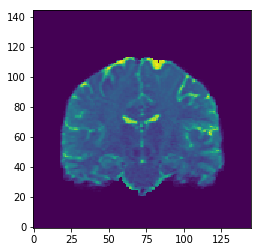

In [8]:
plt.imshow(data_hcp[:,0,:,0].T, origin=True)

In [9]:
mcsmt_fit_hcp = mcsmt_mod.fit(data_hcp, mask=data_hcp[..., 0]>0)

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 43.4761419296 seconds.
Average of 0.0053142821085 seconds per voxel.


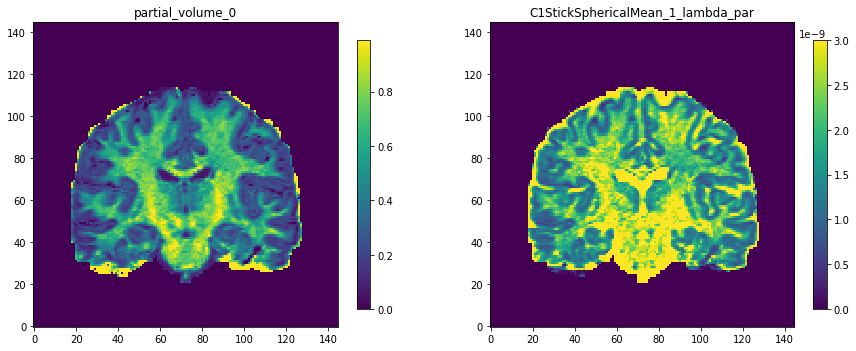

In [10]:
fitted_parameters = mcsmt_fit_hcp.fitted_parameters

fig, axs = plt.subplots(1, len(fitted_parameters), figsize=[15, 15])
axs = axs.ravel()

for i, (name, values) in enumerate(fitted_parameters.items()):
    cf = axs[i].imshow(values.squeeze().T, origin=True)
    axs[i].set_title(name)
    fig.colorbar(cf, ax=axs[i], shrink=0.33)

It is also possible to calculate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination.  
In MSE, the lower the better, while $R^2$ ranges between 0 and 1, with 1 being a perfect model fit.

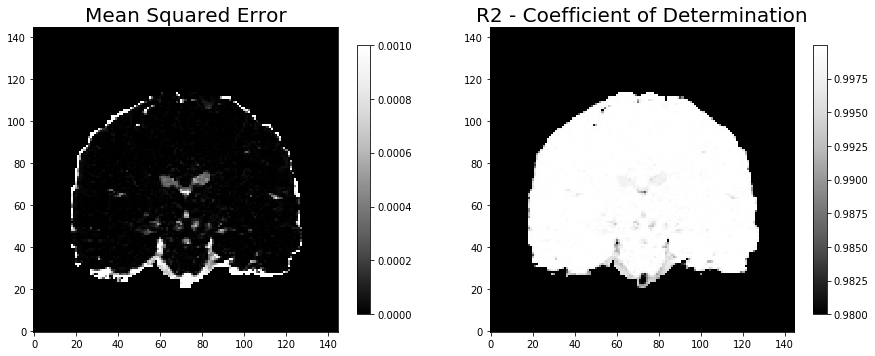

In [39]:
mse = mcsmt_fit_hcp.mean_squared_error(data_hcp)
R2 = mcsmt_fit_hcp.R2_coefficient_of_determination(data_hcp)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=1e-3, cmap='Greys_r')
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=.98, cmap='Greys_r')
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20);

The MSE shows that the fitting error is very low overall, with only slightly higher errors in the CSF and much larger errors in the skull. The $R^2$ agree with the MSE results, having values very close to 1 overall, with lower values in the CSF and skull.